In [1]:
import sys,os
import time 
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy
import scipy.signal as sig
import scipy.optimize as opt

import h5py

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf

from scipy.signal import periodogram,get_window,coherence,welch,csd
from scipy.interpolate import interp1d

from matplotlib.lines import Line2D

from pandas import *

# Noise cleaning to get coefficents

In [2]:
# noise_series = "20220706_163812"
# pulse_series = "20220706_182122" ## pulse_start_time_sec = 4.9355
# pulse_series = "20220706_181948" ## pulse_start_time_sec = 5.0120
# pulse_series = "20220706_181818" ## pulse_start_time_sec = 4.6920
# pulse_series = "20220706_181644" ## pulse_start_time_sec = 4.8025
# pulse_series = "20220706_181510" ## pulse_start_time_sec = 5.7545
# pulse_series = "20220706_181335" ## pulse_start_time_sec = 5.8785

noise_series = "20220715_150554"
pulse_series = "20220715_143744" ## pulse_start_time_sec = 4.8555

## Extract the noise files
sum_file_noise, dly_file_noise, vna_file_noise, tone_files_noise = Thf.GetFiles(noise_series, verbose=False)
metadata_noise, avg_frqs_noise, avg_S21s_noise = Thf.UnpackSummary(sum_file_noise)
noise_tone_file = tone_files_noise[0]

## Extract the pulse files
sum_file_pulse, dly_file_pulse, vna_file_pulse, tone_files_pulse = Thf.GetFiles(pulse_series, verbose=False)
metadata_pulse, avg_frqs_pulse, avg_S21s_pulse = Thf.UnpackSummary(sum_file_pulse)
pulse_tone_file = tone_files_pulse[0]

Line Delay file:  None
VNA scan file:    /data/USRP_Noise_Scans/20220715/20220715_150554/USRP_VNA_20220715_150554.h5
Timestream files: ['/data/USRP_Noise_Scans/20220715/20220715_150554/USRP_Noise_20220715_150554_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220715/20220715_150554/noise_averages_20220715_150554.h5
Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220715/20220715_150554/USRP_Noise_20220715_150554_delta0.h5 because override=True!
found 4 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 398500)
(1, 398500)
(1, 398500)
(2, 3

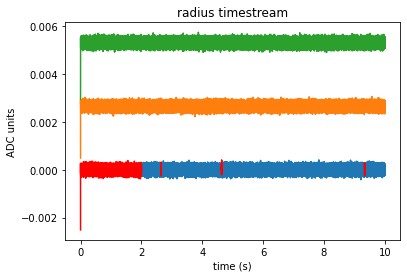

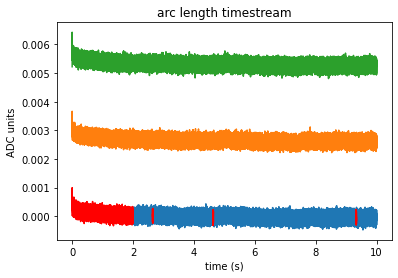

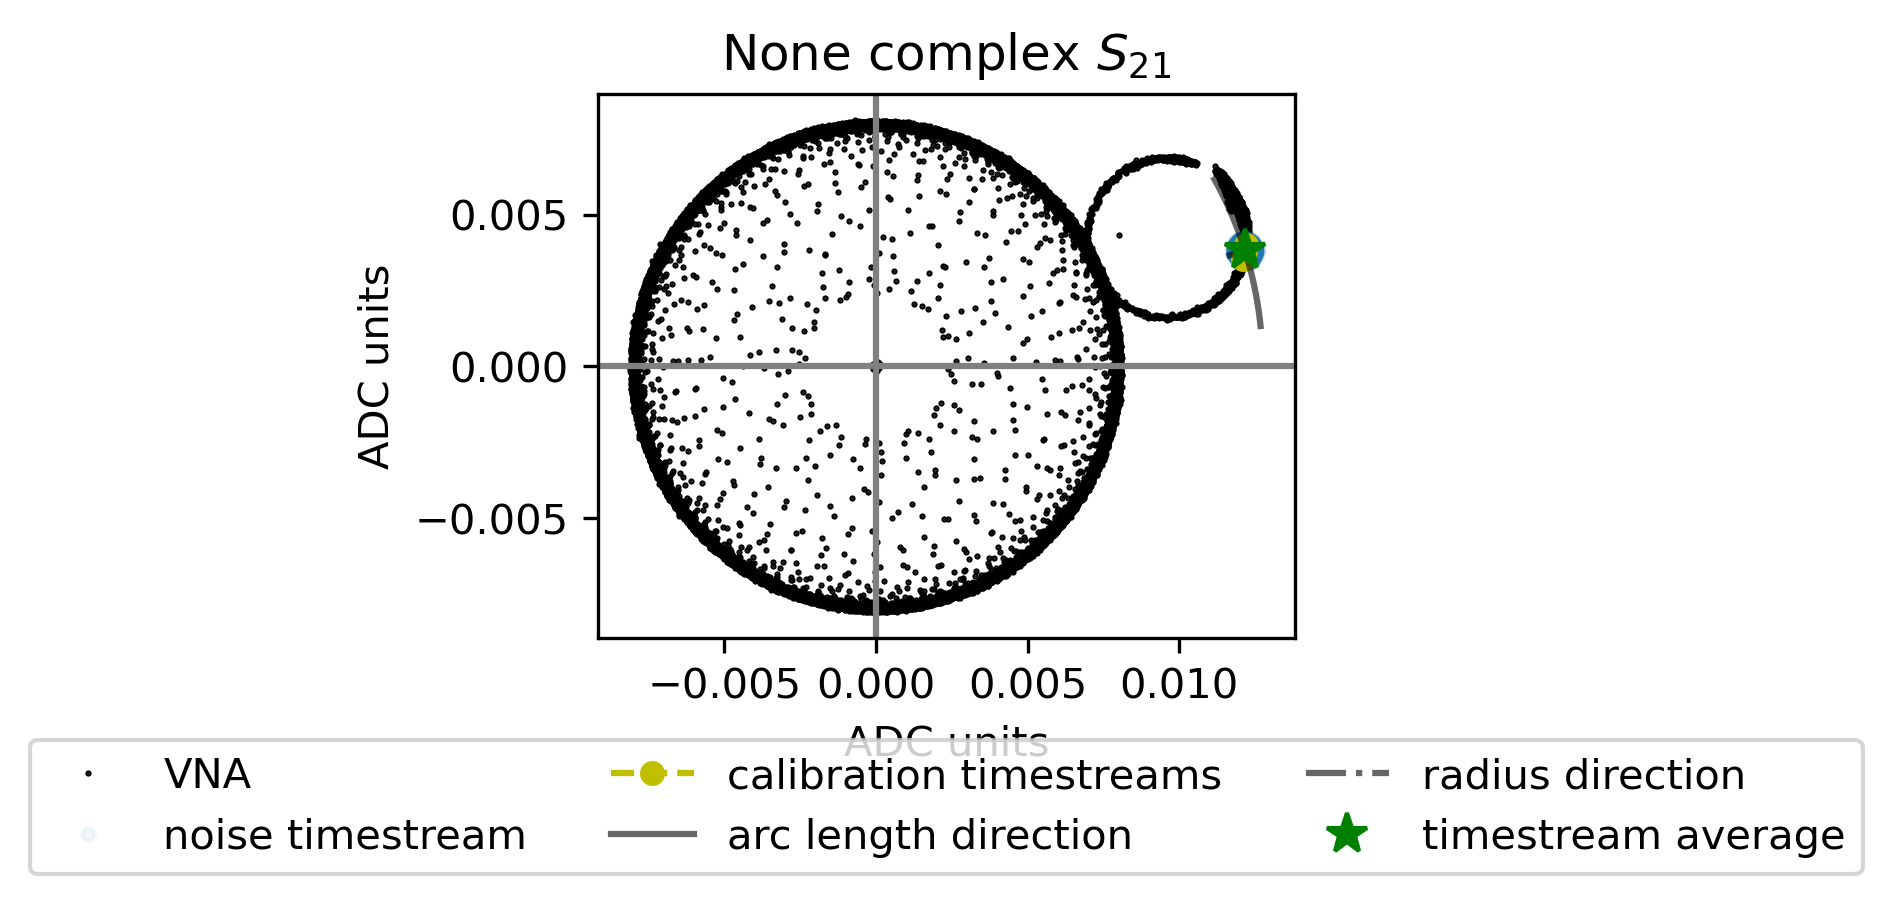

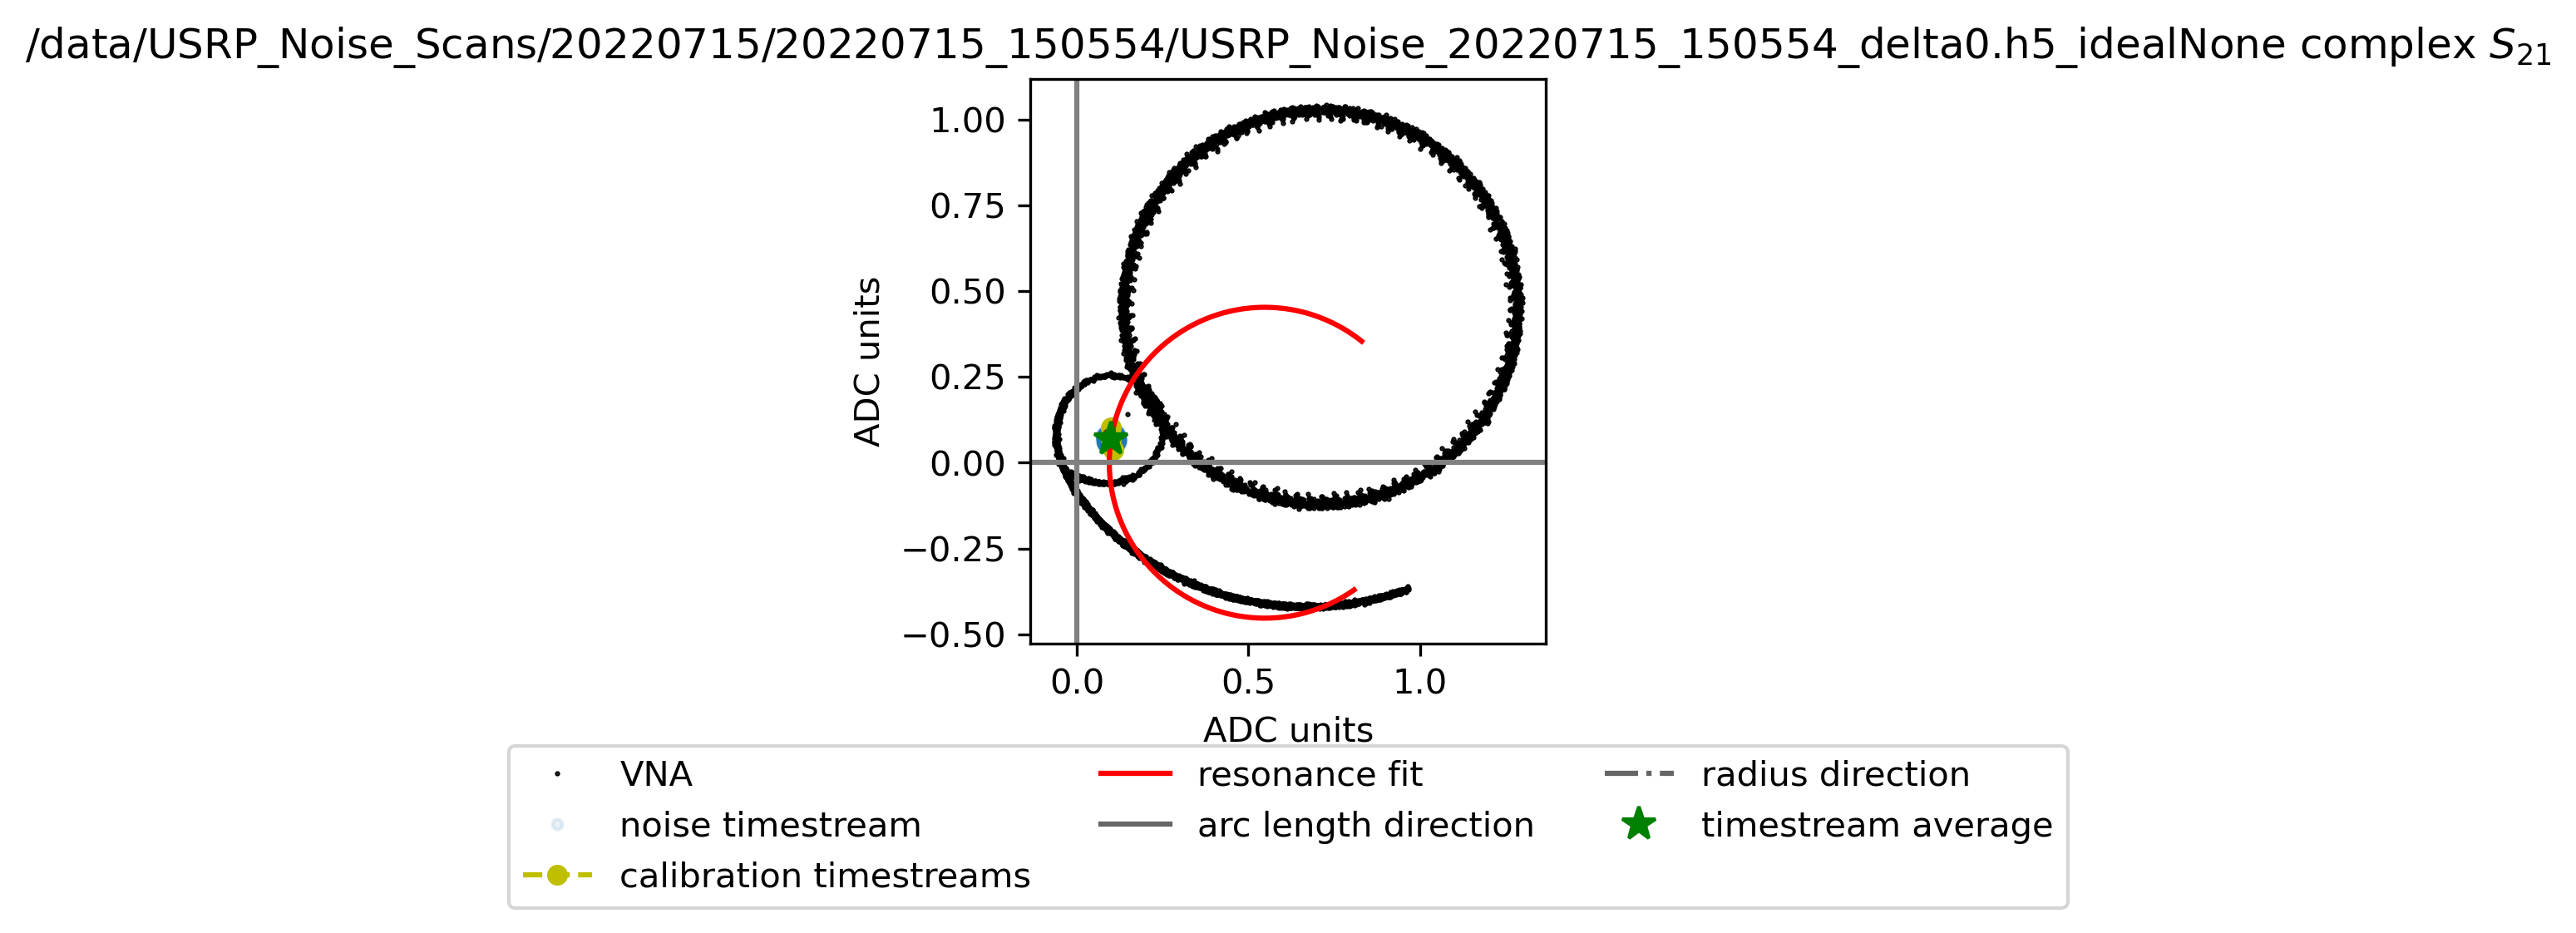

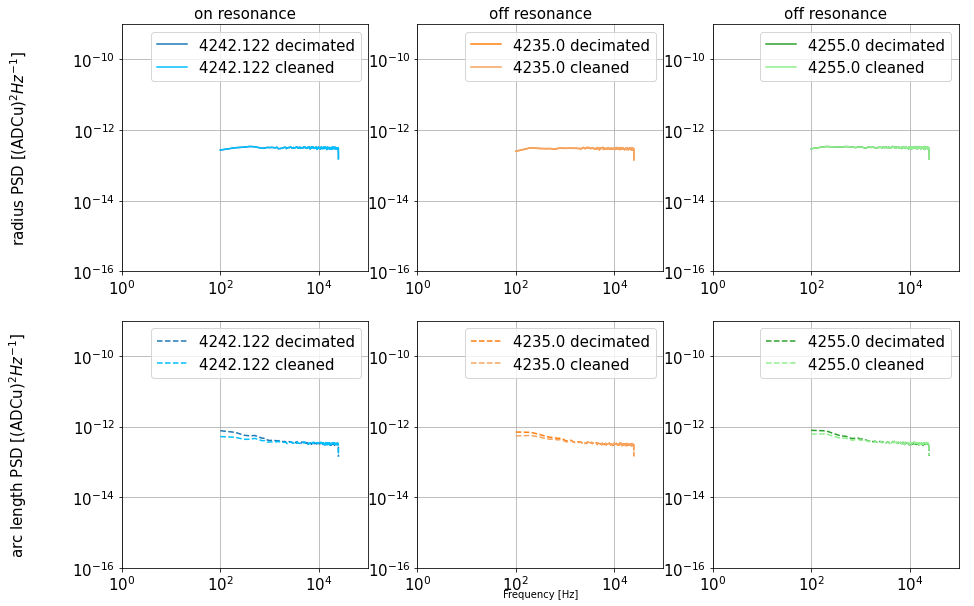

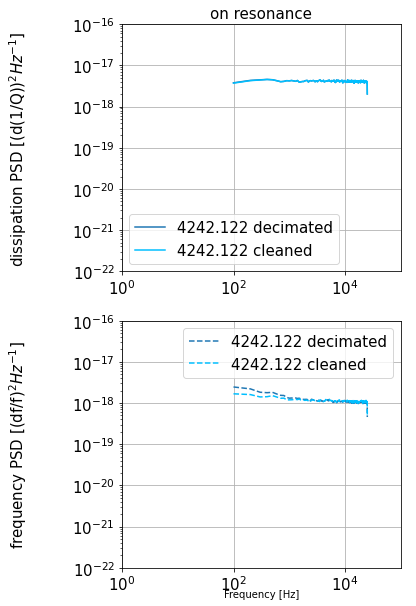

In [3]:
chunk_up_to      = 1e2
decimate_down_to = 5e4
blank_fraction   = 0.2
powers, PSDs, res, timestreams = Thf.CleanPSDs(None, None, noise_series, 
                                               PSD_lo_f=chunk_up_to, 
                                               PSD_hi_f=decimate_down_to, 
                                               f_transient=blank_fraction)

# Pulse Cleaning

20220715_143744 : 4.8555 s
Time between pulse arrivals: 10.0 ms
Before decimation, each window is 10000 samples
Trimmed waveform starts at time 4.855500000000001 seconds
Total number of pulse windows: 514
The window index with the first pulse: 0
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
After decimation, each window is 500 samples
278 0.00556 278 278
used 513 chunks to find quiescent point
[0.00829936 0.01282151 0.01324534]
[ 0.53475623  0.65622718 -0.0639889 ]
built radius and arc length timestreams given by quiescent point
/data/USRP_Noise_Scans/20220715/20220715_150554/USRP_Noise_20220715_150554_delta0.h5
{0.0: array([0.00439771]), 1.0: array([-0.00080288]), 2.0: array([-0.00085085])}
{0.0: array([0.3210194]), 1.0: array([0.19215548]), 2.0: array([0.20512489])}
cleaned tone 0
cleaned tone 1
cleaned tone 2
saving clean_data to /data/USRP_Noise_Scans/20220715/20220715_143744/USRP_Noise_20220715_143744_delta0_cleaned.h5 because override=True!
pulse noise 

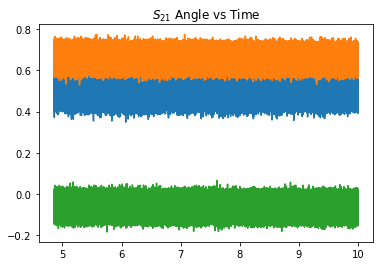

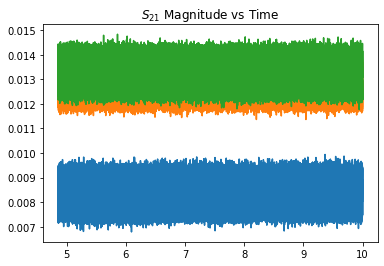

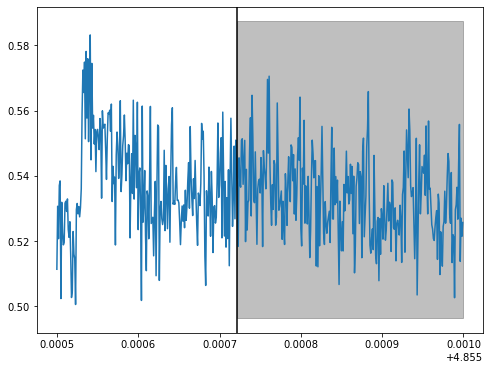

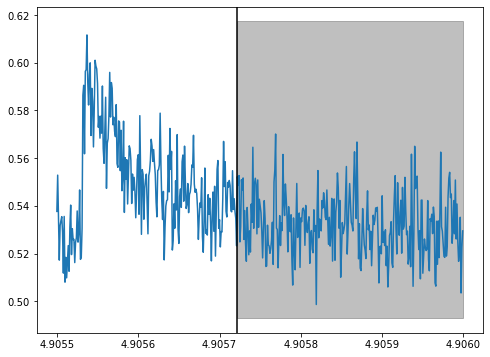

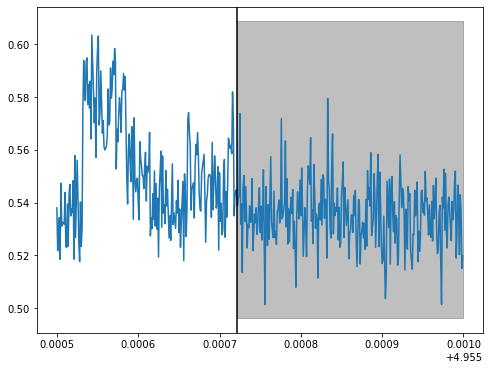

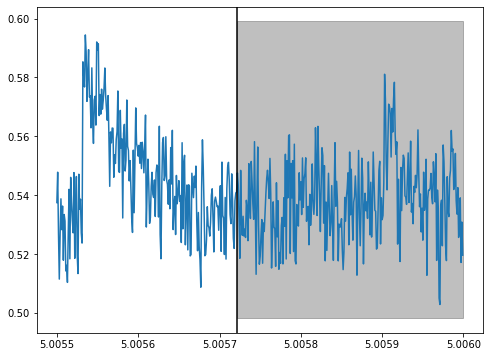

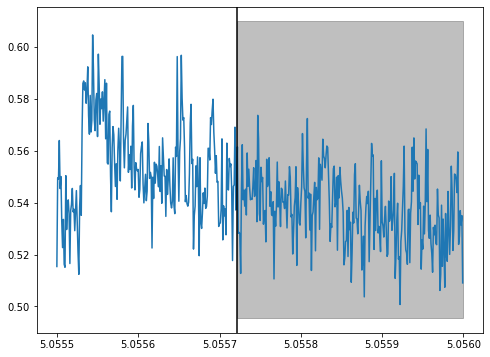

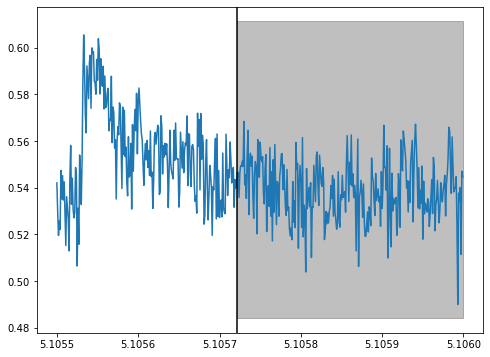

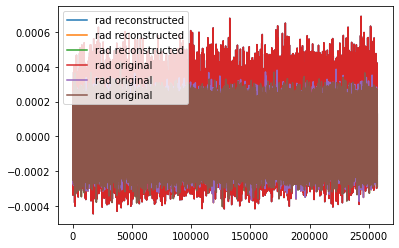

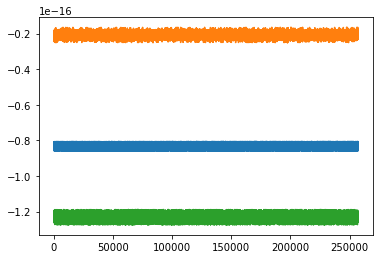

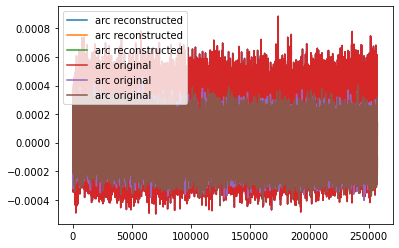

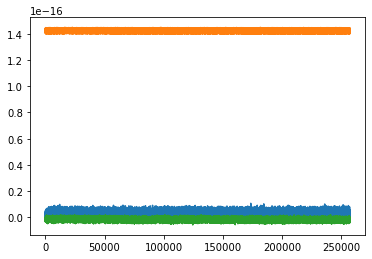

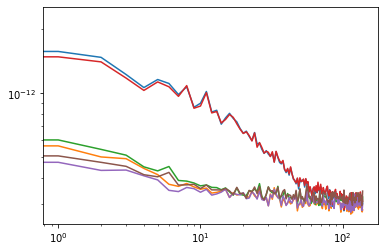

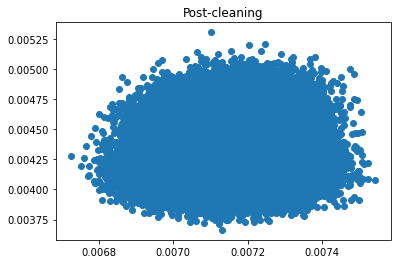

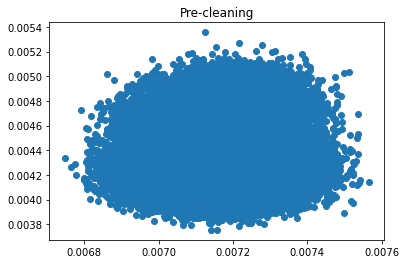

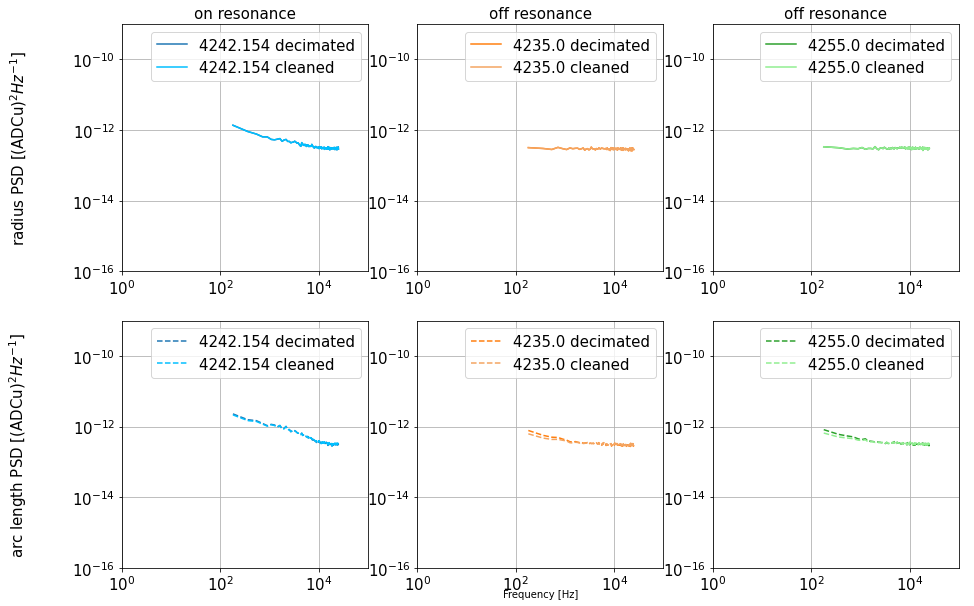

In [16]:
verbose = True

pulse_start_time_sec = 4.8555
pulse_stop_time_sec  = 10.0
pulse_rate_Hz        = 100.

print(pulse_series, ":", pulse_start_time_sec, "s")

## The total time in seconds between pulse arrivals
time_btw_pulse = 1./pulse_rate_Hz
print("Time between pulse arrivals:",1e3*time_btw_pulse,"ms")

## Pull the un-averaged noise timestreams and determine what decimation to apply
pulse_noise, pulse_info = PUf.unavg_noi(pulse_tone_file)
pulse_fs = 1./pulse_info['sampling period']
pulse_cleaning_decimation = int(pulse_fs/decimate_down_to)
samples_per_pulse = int(time_btw_pulse*pulse_fs)
print("Before decimation, each window is",samples_per_pulse,"samples")

## Construct an absolute time array
t_all, _ = Prf.build_t_and_f(len(pulse_noise),pulse_fs)

## Cut off the non-pulse region
pulse_noise = pulse_noise[t_all>pulse_start_time_sec]
t_trim      = t_all[t_all>pulse_start_time_sec]
print("Trimmed waveform starts at time",t_trim[0],"seconds")

## The total number of pulse arrival windows in the timestream
## after the timestream has been cut to only have the pulse region
total_pulses = int(pulse_rate_Hz*(pulse_stop_time_sec-pulse_start_time_sec))
print("Total number of pulse windows:",total_pulses)

## How many windows will actually contain a pulse
num_pulses = total_pulses # pulse_rate_Hz*(pulse_stop_time_sec-pulse_start_time_sec)
# num_pulses = int(total_pulses * (1 - blank_fraction))

## Which window index contains the first pulse
pulse_start = 0 # int(pulse_rate_Hz*pulse_start_time_sec)# 
print("The window index with the first pulse:",pulse_start)

## Show the whole timestream before decimation
plt.figure()
plt.plot(t_trim,np.angle(pulse_noise))
plt.title(r"$S_{21}$ Angle vs Time")

plt.figure()
plt.plot(t_trim,abs(pulse_noise))
plt.title(r"$S_{21}$ Magnitude vs Time")

## Decimate the timestream
pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
pulse_fs /= pulse_cleaning_decimation

print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

## Determine how many samples are in each window of the decimated timestream
## Define a time cut within the window to define the pulse-free region of each window
window_shift_seconds = 3050e-6
window_shift = int(window_shift_seconds * pulse_fs) + 70

## Then build a time and frequency array for such a window
samples_per_pulse = int(time_btw_pulse*pulse_fs)
print("After decimation, each window is",samples_per_pulse,"samples")
# N = int(samples_per_pulse / 2)
N = int(samples_per_pulse - window_shift)
T = N/pulse_fs
t,f = Prf.build_t_and_f(N,pulse_fs)
print(N,T,len(t),len(f))

## Create some containers for the output
noise_averages = np.zeros((3),dtype=np.complex128)
J_r   = np.zeros((N,3))
J_arc = np.zeros((N,3))

## Loop over every pulse window
k  = 0
for pulse_i in range(pulse_start,int(total_pulses)-1,1):
    ## Find the timestream indeces that correspond to start and end of the window
    pulse_i_end   = int((pulse_i+1)*samples_per_pulse) 
    pulse_i_start = int((pulse_i  )*samples_per_pulse)
    
    ## Define the region where there's no pulse response
    no_pulse_idx_start = pulse_i_end - 1 - N # pulse_i_start + window_shift # - N + window_shift
    no_pulse_idx_end   = pulse_i_end - 1# pulse_i_start + window_shift + N #pulse_i_end   - 1 # + window_shift
    
    ## Create a plot of this pulse window
    if (k%100==0):
        plt.figure(figsize=(8,6))
        plt.plot(t_trim[pulse_i_start:pulse_i_end],np.angle(pulse_noise[pulse_i_start:pulse_i_end,0]))
        plt.axvline(x=t_trim[pulse_i_start+window_shift],color='k',ls='-')
        ylims = plt.gca().get_ylim()
        plt.fill_between([t_trim[no_pulse_idx_start],t_trim[no_pulse_idx_end]],y1=ylims[0],y2=ylims[1],color='k',alpha=0.25)
    
    no_pulse_chunk  = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
    noise_averages += np.mean(pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:],axis=0,dtype=np.complex128) / num_pulses    

    r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
    J_r   += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
    J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T
    k += 1

print('used ' + str(k) + ' chunks to find quiescent point')
# if j % 4 == 0:
#     fig, ax = plt.subplots(1,2,figsize=(5,10))
#     ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10))
#     ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10))
#     ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')

# print(noise_averages)
radius_averages = abs(noise_averages)
angle_averages = np.angle(noise_averages)
if verbose:
    print(radius_averages)
    print(angle_averages)

pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
angle_timestream = np.angle(pulse_timestream_rotated)

radius = abs(pulse_noise) - radius_averages
arc = angle_timestream*radius_averages

radius_clean = np.zeros(radius.shape)
arc_clean = np.zeros(arc.shape)

if verbose:
    print('built radius and arc length timestreams given by quiescent point')

    print(noise_tone_file)
_,data_info = PUf.clean_noi(noise_tone_file[:-3]+'_cleaned.h5')

print(data_info['radius cleaning coefficient'])
print(data_info['arc cleaning coefficient'])
for t in range(radius.shape[1]):
    radius_coefficient = data_info['radius cleaning coefficient'][t]
    arc_coefficient = data_info['arc cleaning coefficient'][t]

    if t == 0:
        off_tone_idcs = [1,2]
    elif t == 1:
        off_tone_idcs = [2]
    elif t == 2:
        off_tone_idcs = [1]


    off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
    radius_clean[:,t]= radius[:,t] - radius_coefficient*off_tone_radius

    off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
    arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc

    if verbose: 
        print('cleaned tone ' + str(t))
        
# print("radius",np.var(arc,axis=0))
# print("radius clean",np.var(arc_clean,axis=0))

#     print(np.mean(radius_clean))
radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')

# print("After mean subtraction")
# print("radius",np.var(arc,axis=0))
# print("radius clean",np.var(arc_clean,axis=0))
#     print(np.mean(radius_clean))
#     print(radius_averages.shape, radius_clean.shape)
#     data_clean = (radius_averages+radius_clean)#*np.exp(1j*((arc_clean/radius_averages)+angle_averages))
# data_clean = (np.mean(abs(data_raw),axis=0,dtype=np.float64)+cd1_clean)*np.exp(1j*((cd2_clean/np.mean(abs(data_raw),axis=0,dtype=np.float64))+np.angle(np.mean(data_raw,axis=0,dtype=complex))))
# print(cd1_coeff)

#     data_clean_average = np.mean(data_clean,dtype='float64')
#     print(abs(data_clean_average))
#     print(np.angle(data_clean_average))

# print("RA:",radius_averages)
# print("AA:",angle_averages)

pulse_noise_clean = Prf.save_clean_timestreams(pulse_tone_file,\
                                               radius_averages,\
                                               angle_averages,\
                                               radius_clean,\
                                               arc_clean,\
                                               pulse_fs,\
                                               timestreams['radius coefficient'],\
                                               timestreams['arc coefficient'],\
                                               override=True)

## Now deconstruct data_clean to recover the averages and timestreams
avg_radius = np.mean(abs(pulse_noise_clean),axis=0)
avg_angle  = np.mean(np.angle(pulse_noise_clean),axis=0)

# print("RAc:",avg_radius)
# print("AAc:",avg_angle)

rad_of_t     = abs(pulse_noise_clean) - avg_radius
arc_of_t     = (np.angle(pulse_noise_clean) - avg_angle)*avg_radius

plt.figure()
plt.plot(rad_of_t,label="rad reconstructed")
plt.plot(radius_clean,label="rad original")
plt.legend(loc='best')

plt.figure()
plt.plot(radius_clean-rad_of_t)

plt.figure()
plt.plot(arc_of_t,label="arc reconstructed")
plt.plot(arc_clean,label="arc original")
plt.legend(loc='best')

plt.figure()
plt.plot(arc_clean-arc_of_t)

print("pulse noise",np.var(pulse_noise.real,axis=0),np.var(pulse_noise.imag,axis=0))
print("pulse noise clean",np.var(pulse_noise_clean.real,axis=0),np.var(pulse_noise_clean.imag,axis=0))

J_r_clean   = np.zeros((N,3))
J_arc_clean = np.zeros((N,3))
for pulse_i in range(pulse_start,int(total_pulses)-1,1):                
    pulse_i_end   = int((pulse_i+1)*samples_per_pulse) 
    pulse_i_start = int((pulse_i  )*samples_per_pulse)
    
#     no_pulse_idx_start = pulse_i_end - N + window_shift
#     no_pulse_idx_end   = pulse_i_end + window_shift
    no_pulse_idx_start = pulse_i_start + window_shift # - N + window_shift
    no_pulse_idx_end   = pulse_i_start + window_shift + N #pulse_i_end   - 1 # + window_shift
    no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]

    r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
    J_r_clean   += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
    J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T

plt.figure()
plt.plot(J_arc[f>0])
plt.plot(J_arc_clean[f>0])
# plt.plot(J_arc_clean[f>0]-J_arc[f>0])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.figure()
plt.scatter(pulse_noise_clean.real[:,0],pulse_noise_clean.imag[:,0],ls="None")
plt.title("Post-cleaning")

plt.figure()
plt.scatter(pulse_noise.real[:,0],pulse_noise.imag[:,0],ls="None")
plt.title("Pre-cleaning")

J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
if 0 % 10 == 0:
    fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
    print(pulse_tone_file)
    Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_tone_file,\
                  ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                  data_freqs=pulse_info['search freqs'],\
                  P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                  fig_0=fig_0,axes_0=axes_0)
    # ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10),ls='--')
    # ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10),ls='--')
    # ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')
#     for ax in axes_0:
#         ax[0].set_ylim([10**-20,10**-9])
#         ax[1].set_ylim([10**-20,10**-9])

# Pulse Averaging

Text(0, 0.5, '$\\mathrm{arg}(S_{21})$ [rad]')

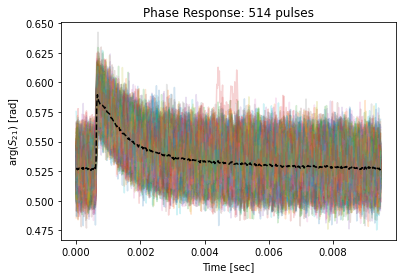

In [5]:
import PulseTriggeringTools as Ptt
tdelta = 0.000
plot_vs_time = True
avg_p, npulses, bl, win = Ptt.StackPulses(pulse_noise_clean[:,0], tdelta,
                                        win_fac=0.95, Npulses=None, 
                                        pulse_rate_Hz=pulse_rate_Hz, sample_rate=pulse_fs,
                                        bl_subtract=False, show_plots=True, plot_time=plot_vs_time)
plt.gca().set_title("Phase Response: "+str(npulses)+" pulses")
plt.gca().set_xlabel(r"Decimated sample index")
if plot_vs_time:
    plt.gca().set_xlabel(r"Time [sec]")
plt.gca().set_ylabel(r"$\mathrm{arg}(S_{21})$ [rad]")

Text(0, 0.5, 'Angle($S_{21}$) [rad]')

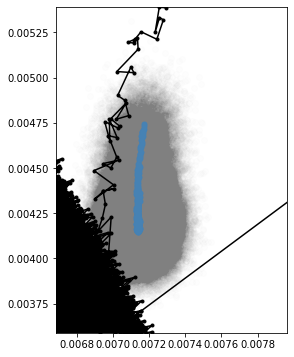

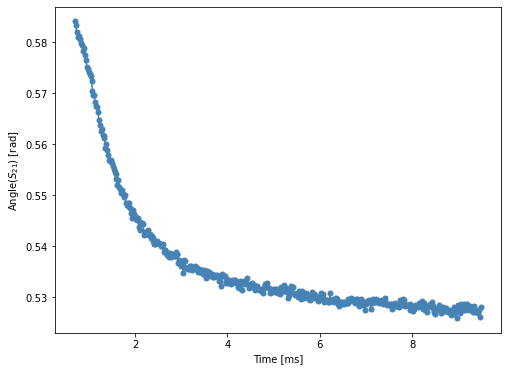

In [10]:
samps_to_skip = 35

avg_p_template = avg_p[samps_to_skip:]

f,z = PUf.read_vna(vna_file_noise)

fig = plt.figure(figsize=(8,6))
ax  = fig.gca()
ax.scatter(pulse_noise_clean[:,0].real,pulse_noise_clean[:,0].imag,color='grey',alpha=1e-2)
ax.plot(avg_p_template.real,avg_p_template.imag,color='steelblue',marker='o',markersize=5,ls='-')
ax.set_aspect('equal','box')

xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.plot(z.real,z.imag,color="k",marker=".",ls='-')
ax.set_xlim([xlims[0],1.05*xlims[1]])
ax.set_ylim(ylims)


plt.figure(figsize=(8,6))
# plt.plot(np.angle(pulse_noise_clean[:,0]),color='grey',alpha=1e-1)
plt.plot(1e3*(samps_to_skip+np.arange(len(avg_p_template)))/pulse_fs,np.angle(avg_p_template),color='steelblue',marker='o',markersize=5,ls='-')
plt.xlabel("Time [ms]")
plt.ylabel(r"Angle($S_{21}$) [rad]")

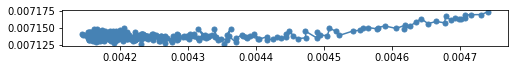

In [11]:
fig = plt.figure(figsize=(8,6))
ax  = fig.gca()
# ax.scatter(pulse_noise_clean[:,0].imag,pulse_noise_clean[:,0].real,color='grey',alpha=1e-2)
ax.plot(avg_p_template.imag,avg_p_template.real,color='steelblue',marker='o',markersize=5,ls='-')
ax.set_aspect('equal','box')

Estimated values: r= 2.76668918776983e-05 x0= 0.0071282798704143755 y0= 0.004128073527244286
Optml fit values: r= 2.76668918776983e-05 x0= 0.0071282798704143755 y0= 0.004128073527244286


/home/nexus-admin/NEXUS_RF/AnalysisScripts/CircleFitter.py:6: RuntimeWarning: invalid value encountered in sqrt
  return y0 + np.sqrt(np.power(r,2) - np.power(x-x0,2))
/usr/local/share/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/nexus-admin/NEXUS_RF/AnalysisScripts/CircleFitter.py:6: RuntimeWarning: invalid value encountered in sqrt
  return y0 + np.sqrt(np.power(r,2) - np.power(x-x0,2))
/home/nexus-admin/NEXUS_RF/AnalysisScripts/CircleFitter.py:9: RuntimeWarning: invalid value encountered in sqrt
  return y0 - np.sqrt(np.power(r,2) - np.power(x-x0,2))
/home/nexus-admin/NEXUS_RF/AnalysisScripts/CircleFitter.py:6: RuntimeWarning: invalid value encountered in sqrt
  return y0 + np.sqrt(np.power(r,2) - np.power(x-x0,2))
/home/nexus-admin/NEXUS_RF/AnalysisScripts/CircleFitter.py:9: RuntimeWarning: invalid value encountere

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabe'

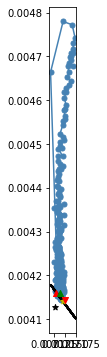

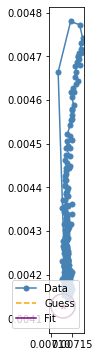

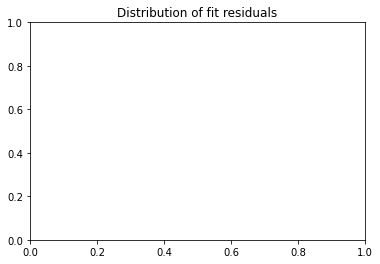

In [8]:
import CircleFitter as cf

x_data = avg_p_template.real
y_data = avg_p_template.imag

par_est = cf.estimate_circ_params(x_data, y_data, show=True)
par_fit, pcov_fit, circ_ch = cf.fit_data_circle(x_data, y_data, par_est)
cf.plot_data_est_fit(x_data, y_data, est_vals=par_est, fit_vals=par_fit)
cf.plot_fit_residuals(x_data, y_data, par_fit, circ_ch)

In [ ]:
## Translate the data to lie at the origin
complex_center = par_fit[1] + 1j*par_fit[2]
avg_p_template = avg_p_template - complex_center

In [ ]:
angles = np.angle(avg_p_template)
angles[angles<0] = 2*np.pi + angles[angles<0]

plt.figure(figsize=(8,6))
plt.scatter(pulse_noise_clean[:,0].real-par_fit[1],pulse_noise_clean[:,0].imag-par_fit[2],color='grey',alpha=1e-2)
plt.plot(avg_p_template.real,avg_p_template.imag,color='steelblue',marker='o',markersize=5,ls='-')
plt.axhline(y=0,color='k',ls='--')
ax = plt.gca(); ax.set_aspect('equal','box')

plt.figure(figsize=(8,6))
# plt.plot(np.angle(pulse_noise_clean[:,0]),color='grey',alpha=1e-1)
plt.plot((angles/np.pi),color='steelblue',marker='o',markersize=5,ls='-')
plt.xlabel(r"Phase angle [rad/$\pi$]")
plt.axhline(y=1,color='k',ls='--')

In [ ]:
plt.figure(figsize=(8,6))
# plt.plot(np.angle(pulse_noise_clean[:,0]),color='grey',alpha=1e-1)
plt.plot((np.max(angles)-angles)/np.pi, abs(avg_p_template) ,color='steelblue',marker='o',markersize=5,ls='-')
plt.xlabel(r"Phase angle [rad/$\pi$]")